In [1]:

from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")



Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
from utilities.utils import read_gt_folder,mean_embed_sublist
ground_truth_gt = read_gt_folder("datasets/extracted section gpt/final/all/")
ground_truth_gt = {key:value for key,value in ground_truth_gt.items() if len(value)>0}
ground_truth_gt = {key:[v for v in value if len(v)>0] for key,value in ground_truth_gt.items() }
emb_dict_gt = {key:mean_embed_sublist(model,tokenizer,value) for key,value in ground_truth_gt.items()}
#----
from algorithms.core_algorithm import *
trivial = Trivial('datasets/STL_original_article.xls', 'datasets/raw articles/all/', encode=True)
trivial.load_data()
trivial_result = trivial.run_algorithm()
trivial_result = {key:list(set([v for v in value if len(v)>0])) for key,value in trivial_result.items() }
emb_dict_trivial = {key:mean_embed_sublist(model,tokenizer,value) for key,value in trivial_result.items() if len(value)>0}
#----
from algorithms.core_algorithm import *
fuzzy = Fuzzy('datasets/STL_original_article.xls', 'datasets/raw articles/all/', encode=True)
fuzzy.load_data()
fuzzy_result = fuzzy.run_algorithm()
fuzzy_result = {key:list(set([v for v in value if len(v)>0])) for key,value in fuzzy_result.items() }
emb_dict_fuzzy = {key:mean_embed_sublist(model,tokenizer,value) for key,value in fuzzy_result.items() if len(value)>0}

#----------
from algorithms.core_algorithm import uNER_fast

uNER = uNER_fast('datasets/labels_final.txt','datasets/raw articles/all/',True,model,tokenizer)
uNER.load_data()
uNER_results = uNER.run_algorithm()
from utilities.utils import read_gt_folder,mean_embed_sublist
uNER_results = {key:[v for value in values for v in value] for key,values in uNER_results.items()}
emb_dict_uNER = {key:mean_embed_sublist(model,tokenizer,value) for key,value in uNER_results.items() if len(value)>0}

#----------
# random
#----------
# random
import random
from algorithms.core_algorithm import *
trivial = Trivial('datasets/STL_original_article.xls', 'datasets/raw articles/all/', encode=True)
trivial.load_data()
random_result = {key:random.sample(value.split(),5)for key,value in trivial.corpus.items() if len(value)>0}
emb_dict_random = {key:mean_embed_sublist(model,tokenizer,value) for key,value in random_result.items() if len(value)>0}




result1 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_trivial.values())])
result2 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_fuzzy.values())])
result3 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_uNER.values())])

result4 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_random.values())])

from plotting.plots import plot_histograms_metric
plot_histograms_metric(result1,result2,result3,result4)


[nltk_data] Downloading package punkt to /home/gerard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gerard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


count of labels in datasets/labels_final.txt: 30522


100%|██████████| 51/51 [08:53<00:00, 10.46s/it]


In [18]:
import random


['b', 'd']

In [3]:

import torch
import torch.nn.functional as F

# Assuming `tensor1` and `tensor2` are the given tensors of shape [n, 768] and [m, 768]
# Placeholder tensors for the sake of demonstration
def metric(tensor1,tensor2):
    # Normalize the tensors along the last dimension
    tensor1_norm = F.normalize(tensor1, p=2, dim=1)
    tensor2_norm = F.normalize(tensor2, p=2, dim=1)

    # Compute pairwise cosine similarity
    similarity_matrix = torch.matmul(tensor1_norm, tensor2_norm.transpose(0, 1))

    # Select the highest similarity for each row
    highest_similarity, selected_indices = torch.max(similarity_matrix, dim=1)

    # Retrieve the selected tensors from tensor2
    selected_tensors = tensor2[selected_indices]
    return highest_similarity.mean()







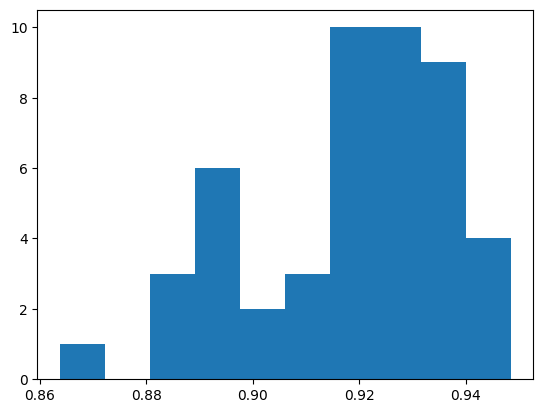

In [4]:
result1 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_trivial.values())])

import matplotlib.pyplot as plt
plt.hist(result1)
plt.show()

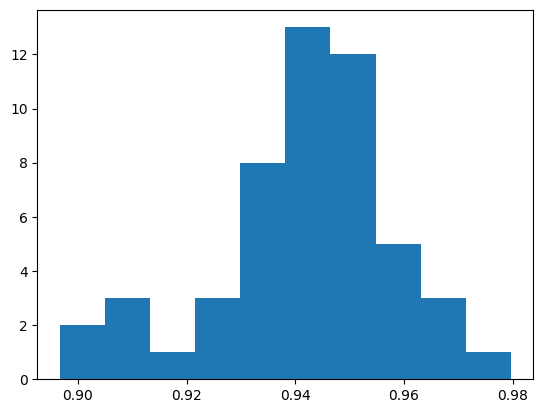

In [5]:
result2 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_fuzzy.values())])

import matplotlib.pyplot as plt
plt.hist(result2)
plt.show()

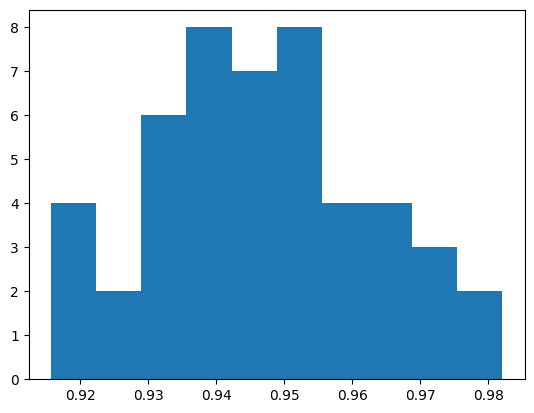

In [11]:
result3 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_uNER.values())])

import matplotlib.pyplot as plt
plt.hist(result3)
plt.show()

In [24]:
result1 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_trivial.values())])
result2 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_fuzzy.values())])
result3 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_uNER.values())])

result4 = np.array([metric(tensor1,tensor2) for tensor1,tensor2 in zip(emb_dict_gt.values(),emb_dict_random.values())])

from plotting.plots import plot_histograms_metric
plot_histograms_metric(result1,result2,result3,result4)

TypeError: plot_histograms_metric() takes 3 positional arguments but 4 were given